In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
#!pip install tensorflow==2.12.0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc)
from dotenv import load_dotenv

In [ ]:
load_dotenv()
Data_Path = os.getenv("Data_Path")

In [3]:
# Collect data from all CSVs
all_data = []
for folder in os.listdir(Data_Path):
    folder_path = os.path.join(Data_Path, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(folder_path, file))
                all_data.append(df)

df_all = pd.concat(all_data, ignore_index=True)


In [4]:
# Use a subset for simplicity (you can expand to all data)
sequence_df = df_all[['Voltage', 'Current', 'Temperature', 'SOC']].copy()

# Normalize
scaler = MinMaxScaler()
sequence_df[:] = scaler.fit_transform(sequence_df)

# Create sequences (window of past 20 timesteps to predict next SOC)
def create_sequences(data, sequence_length=20):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :-1])  # features
        y.append(data[i + sequence_length, -1])     # SOC
    return np.array(X), np.array(y)

data_np = sequence_df.to_numpy()
X_lstm, y_lstm = create_sequences(data_np, sequence_length=20)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)


In [5]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train_lstm, y_train_lstm, validation_split=0.2, epochs=10, batch_size=64)

# Predict and Evaluate
y_pred_lstm = model.predict(X_test_lstm).flatten()
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm)))
print("LSTM R²:", r2_score(y_test_lstm, y_pred_lstm))


Epoch 1/10
90473/90473 [==============================] - 1219s 13ms/step - loss: 8.6411e-04 - val_loss: 3.0931e-04
Epoch 2/10
90473/90473 [==============================] - 1351s 15ms/step - loss: 6.2433e-04 - val_loss: 2.7881e-04
Epoch 3/10
90473/90473 [==============================] - 1258s 14ms/step - loss: 6.0282e-04 - val_loss: 2.8222e-04
Epoch 4/10
90473/90473 [==============================] - 1156s 13ms/step - loss: 5.9156e-04 - val_loss: 2.6707e-04
Epoch 5/10
90473/90473 [==============================] - 1266s 14ms/step - loss: 5.8379e-04 - val_loss: 2.6804e-04
Epoch 6/10
90473/90473 [==============================] - 1263s 14ms/step - loss: 5.7805e-04 - val_loss: 2.6556e-04
Epoch 7/10
90473/90473 [==============================] - 1395s 15ms/step - loss: 5.7345e-04 - val_loss: 2.5711e-04
Epoch 8/10
90473/90473 [==============================] - 1222s 14ms/step - loss: 5.6934e-04 - val_loss: 2.6596e-04
Epoch 9/10
90473/90473 [==============================] - 1228s 14ms/ste

In [9]:
rmse = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
r2 = r2_score(y_test_lstm, y_pred_lstm)

In [12]:
epochs = 10
print(f"Test: Epoch {epochs}")
print(f"Test R²: {r2:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")

Test: Epoch 10
Test R²: 0.996
Test RMSE: 0.016
Test MAE: 0.011


In [13]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer
from tensorflow.keras.utils import to_categorical

# Step 1: Define number of bins for classification
n_bins = 10  # You can choose 5, 10, etc.

# Step 2: Bin SOC into discrete classes using KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_test_cls = discretizer.fit_transform(y_test_lstm.reshape(-1, 1)).astype(int).flatten()
y_pred_cls = discretizer.transform(y_pred_lstm.reshape(-1, 1)).astype(int).flatten()

# Step 3: Compute classification metrics
accuracy = accuracy_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls, average='macro')  # macro = class-agnostic average
y_test_onehot = to_categorical(y_test_cls, num_classes=n_bins)
y_pred_onehot = to_categorical(y_pred_cls, num_classes=n_bins)

# Step 4: Calculate AUC using one-vs-rest
try:
    auc = roc_auc_score(y_test_onehot, y_pred_onehot, multi_class='ovr')
except ValueError:
    auc = None  # In case some bins are missing

# Step 5: Print results in your format
epochs = 10  # change to your actual training epoch count
print(f"Test: Epoch {epochs}")
print(f"Test ACC: {accuracy:.3f}")
print(f"Test F1: {f1:.3f}")
print(f"Test AUC: {auc:.3f}" if auc is not None else "Test AUC: N/A (insufficient class coverage)")


Test: Epoch 10
Test ACC: 0.897
Test F1: 0.898
Test AUC: 0.942


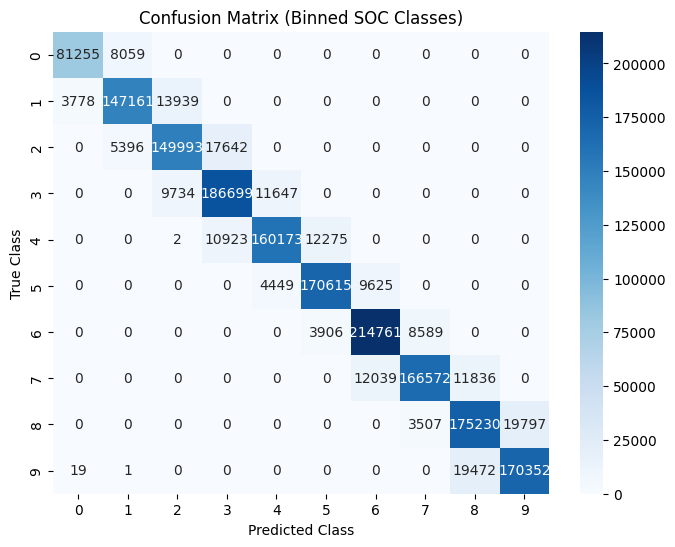

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.96      0.91      0.93     89314
     Class 1       0.92      0.89      0.90    164878
     Class 2       0.86      0.87      0.87    173031
     Class 3       0.87      0.90      0.88    208080
     Class 4       0.91      0.87      0.89    183373
     Class 5       0.91      0.92      0.92    184689
     Class 6       0.91      0.95      0.93    227256
     Class 7       0.93      0.87      0.90    190447
     Class 8       0.85      0.88      0.87    198534
     Class 9       0.90      0.90      0.90    189844

    accuracy                           0.90   1809446
   macro avg       0.90      0.90      0.90   1809446
weighted avg       0.90      0.90      0.90   1809446



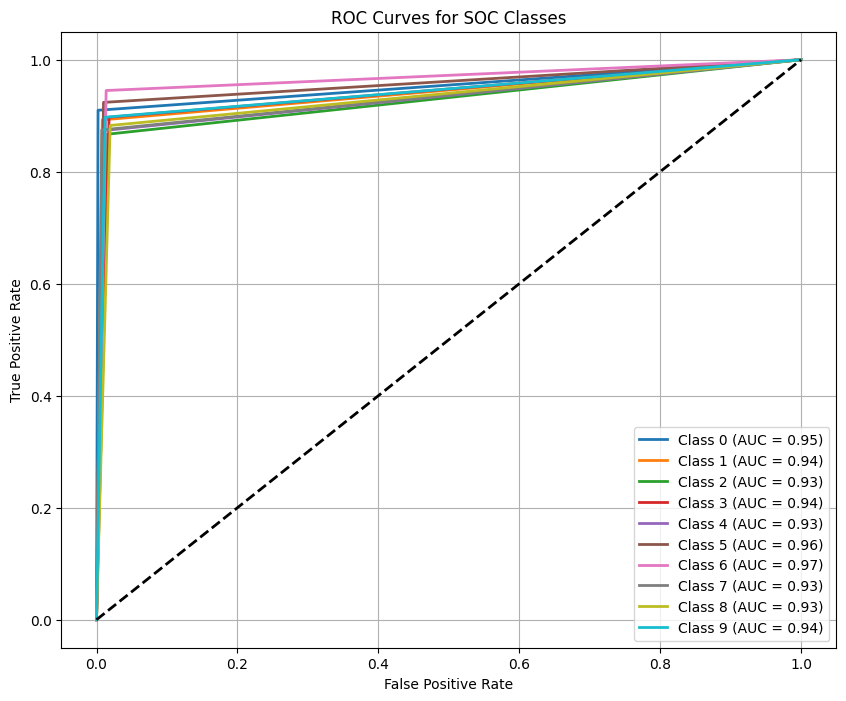

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_cls, y_pred_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_bins), yticklabels=range(n_bins))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix (Binned SOC Classes)')
plt.show()

# Per-Class Accuracy and F1 Score
print("Classification Report:\n")
print(classification_report(y_test_cls, y_pred_cls, target_names=[f'Class {i}' for i in range(n_bins)]))

# ROC Curves for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(n_bins):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SOC Classes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
